# Demo version 06.05.2022

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import lusi_Andreas_Loehr as lal

In [3]:
# Load functinos into global namespace
modify_metric = lal.modify_metric

## Load Data

In [4]:
# Load dataset, set batch size.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [5]:
# Prep train dataset.
eights = x_train[y_train == 8]/255
sevens = x_train[y_train == 7]/255

y_eights = np.ones(eights.shape[0])
y_sevens = np.zeros(sevens.shape[0])

# not needed as 
# eights_flat = np.reshape(eights, (-1, 784))
# sevens_flat = np.reshape(sevens, (-1, 784))
# x_train = np.concatenate([eights_flat, sevens_flat])

x_train_2d = np.concatenate([eights, sevens])
y_train = np.concatenate([y_eights, y_sevens])

In [6]:
# Dim checks.
print(f"Shape of 'eights' data: {eights.shape}")
print(f"Shape of 'sevens' data: {sevens.shape}")
print(f"Shape of entire training dataset: {x_train_2d.shape}")
print(f"Shape of training dataset labels: {y_train.shape}")

Shape of 'eights' data: (5851, 28, 28)
Shape of 'sevens' data: (6265, 28, 28)
Shape of entire training dataset: (12116, 28, 28)
Shape of training dataset labels: (12116,)


In [7]:
# Prep test dataset.
eights_test = x_test[y_test == 8]/255
sevens_test = x_test[y_test == 7]/255

y_eights_test = np.ones(eights_test.shape[0])
y_sevens_test = np.zeros(sevens_test.shape[0])

x_test = np.concatenate([eights_test, sevens_test])
y_test = np.concatenate([y_eights_test, y_sevens_test])

In [8]:
# Dim checks.
print(f"Shape of 'eights' test data: {eights_test.shape}")
print(f"Shape of 'sevens' test data: {sevens_test.shape}")
print(f"Shape of entire test dataset: {x_test.shape}")
print(f"Shape of entire test dataset labels: {y_test.shape}")

Shape of 'eights' test data: (974, 28, 28)
Shape of 'sevens' test data: (1028, 28, 28)
Shape of entire test dataset: (2002, 28, 28)
Shape of entire test dataset labels: (2002,)


In [9]:
# Load numpy array of predicate functions
preds = lal.phi
preds

array([<function avg_pixel_intensity at 0x1a0ba4790>,
       <function weighted_pixel_intesity at 0x1a0ba4940>,
       functools.partial(<function local_pixel_intensity_single at 0x1a0ba49d0>, patch=((10, 20), (10, 20)))],
      dtype=object)

In [10]:
# Evaluate predicates on training data
pred_eval = lal.apply_predicates_on_data(preds, x_train_2d)
pred_eval_test = lal.apply_predicates_on_data(preds, x_test)

2022-05-07 11:31:36.387081: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Dim checks.
print(f"Type of pred_eval is: {type(pred_eval)}\n")
print(f"Shape of pred_eval is: {pred_eval.shape}. This is the result of applying {preds.shape[0]} predicates on the training data.\n")
print(f"Shape of pred_eval_test is: {pred_eval_test.shape}. This is the result of applying {preds.shape[0]} predicates on the test data.\n")
print(f"Shape of train dataset is: {x_train_2d.shape}")
print(f"Shape of training labels is: {y_train.shape}")

Type of pred_eval is: <class 'tensorflow.python.framework.ops.EagerTensor'>

Shape of pred_eval is: (12116, 3). This is the result of applying 3 predicates on the training data.

Shape of pred_eval_test is: (2002, 3). This is the result of applying 3 predicates on the test data.

Shape of train dataset is: (12116, 28, 28)
Shape of training labels is: (12116,)


In [15]:
# Batch training dataset and prepare for training with custom lusi loss.
# Important: Set reminder to true, else B in custom training loop might greater than batch_size of last batch.
train_dataset = tf.data.Dataset.from_tensor_slices((pred_eval, x_train_2d, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

### Zipped train datasets

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((pred_eval, x_train_2d, y_train))


train_dataset_b = train_dataset.shuffle(buffer_size=1024).batch(64, drop_remainder=True)
train_dataset_b_prime = train_dataset.shuffle(buffer_size=1024).batch(54, drop_remainder=True)

In [633]:
class Periphery:
    def __init__(self, train_data=None, test_data=None, n_train=None, n_test=None, 
                 model=None, phi=None, batch_size_1=32, batch_size_2=32) -> None:
        
        """Bind all data and objetcs for Lusi method.
        
        Parameters:
        train_data :: tuple of np.ndarrays - (x_train, y_train) | None
            Training data.
        
        test_data :: tuple of np.ndarrays - (x_test, y_test) | None
            Test data.
        
        n_train :: int | None 
            Number of samples to be used for training.
            If None, use entire train_data.
            
        n_test :: int | None
            Number of samples to be used for testing.
            If None, use entire test_data.
        
        model :: tensorflow model | None
            Either compiled tf model or LusiModel instance.
            
        phi :: np.ndarray[list[function]]
            A numpy array of list of functions to be applied on x_data.
        
        batch_size_1 :: int
            Batch size B from paper. This batch size is used in training.
            Default value: 32.
            
        batch_size_2 :: int
            Batch size B' from paper. This batch size is used in training.
            Default value: 32.        
        """
        
        self.train_data = train_data
        self.test_data = test_data
        self.n_train = n_train
        self.n_test = n_test
        self.phi = phi
        self.batch_size_1 = batch_size_1
        self.batch_size_2 = batch_size_2
       
        if self.train_data:
            self.generate_batched_data(train=True)
        
        if self.test_data:
            self.generate_batched_data(train=False)
            
        if self.n_train:
            pass
            
    
    
    def generate_batched_data(self, train=True):
        if train:
            self.train_data_batched_p = self.batch_train(include_phi=True)
            self.train_data_batched_nop = self.batch_train(include_phi=False)
        else:
            # test data
            self.test_data_batched_p = self.batch_test(include_phi=True)
            self.test_data_batched_nop = self.batch_test(include_phi=False)
        return None
    
    
    def shrink_data(self, train=True):
        # Not like this. Cannot shrink it here if already shrunk in batch_train or batch_test method
        pass
    
    
    def batch_train(self, include_phi=True):
        
        data = self.train_data
        n = self.n_train
        
        if not data:
            raise ValueError("No data provided.")
        
        if not n:
            x = data[0]
            y = data[1]
                
        else:
            # Do not use entire dataset.
            indices = np.random.randint(0, data[0].shape[0], size=n)
            x = data[0][indices]
            y = data[1][indices]
            
            self.class_balance = {0 : y[y==0].shape, 1 : y[y==1].shape}

        if include_phi:
            # also implies training with two batches desired, i.e. Lusi training
            phi_x = self.apply_phi(x)
            dataset = tf.data.Dataset.from_tensor_slices((phi_x, x, y))   

            batch_dataset_1 = dataset.shuffle(buffer_size=1024).batch(self.batch_size_1, drop_remainder=True)
            batch_dataset_2 = dataset.shuffle(buffer_size=1024).batch(self.batch_size_2, drop_remainder=True)

            return tf.data.Dataset.zip((batch_dataset_1, batch_dataset_2))            

        else:
        # return basic batch dataset for regular keras model
            dataset = tf.data.Dataset.from_tensor_slices((x, y))
            return dataset.shuffle(buffer_size=1024).batch(self.batch_size_1, drop_remainder=False)

    
    def batch_test(self, include_phi=True):
        
        data = self.test_data
        n = self.n_test
        
        if not data:
            raise ValueError("No data provided.")
        
            if not n:
                x = data[0]
                y = data[1]
                
            else:
                # Do not use entire dataset.
                indices = np.random.randint(0, data[0].shape[0], size=n)
                x = data[0][indices]
                y = data[1][indices]
                
            if include_phi:
                # also implies training with two batches desired, i.e. Lusi training
                phi_x = self.apply_phi(x)
                dataset = tf.data.Dataset.from_tensor_slices((phi_x, x, y))   

                batch_dataset_1 = dataset.shuffle(buffer_size=1024).batch(self.batch_size_1, drop_remainder=True)
                batch_dataset_2 = dataset.shuffle(buffer_size=1024).batch(self.batch_size_2, drop_remainder=True)

                return tf.data.Dataset.zip((batch_dataset_1, batch_dataset_2))            

            else:
            # return basic batch dataset for regular keras model
                dataset = tf.data.Dataset.from_tensor_slices((x, y))
                return dataset.shuffle(buffer_size=1024).batch(self.batch_size_1, drop_remainder=False)

            
    def apply_phi(self, x) -> None:
            """ Evaluate predicates on x and store values.

            Parameters: 
            x :: np.ndarray
                Data to apply predicates to of dimensinos (n, d0, ..., dN).
                For MNIST, dims = (n, 28, 28)

            Returns:
            Tensor of dimensions (n, d).
            """

            phi_x = np.asarray([self.phi[i](x[j]) for j in range(x.shape[0]) for i in range(self.phi.shape[0])])
            phi_x = phi_x.reshape(x.shape[0], self.phi.shape[0])
            phi_x = tf.convert_to_tensor(phi_x, dtype=tf.float32)

            return phi_x
    
    
    def set_batch_sizes(self, batch_sizes : tuple) -> None:
        self.batch_size_1 = batch_sizes[0]
        self.batch_size_2 = batch_sizes[1]

        return None
    
        
    def set_phi(self, phi : list) -> None:
        self.phi = phi
    
        return None
    
    def set_total_train_size(self, n_train) -> None:
        self.n_train = n_train
        
        return None

    
    def set_total_test_size(self, n_test) -> None:
        self.n_test = n_test
        
        return None
    
    def set_train_data(self, train_data):
        self.train_data = train_data
        self.generate_batched_data(train=True)

        return None
    
    def set_test_data(self, test_data):
        self.test_data = test_data
        self.generate_batched_data(train=False)

        return None

In [587]:
size_s = Periphery((x_train_2d, y_train), (x_test, y_test), n_train=600, phi=lal.phi, batch_size_1=64, batch_size_2=64)
size_m = Periphery((x_train_2d, y_train), (x_test, y_test), n_train=2000, phi=lal.phi, batch_size_1=64, batch_size_2=64)
size_l = Periphery((x_train_2d, y_train), (x_test, y_test), phi=lal.phi, batch_size_1=64, batch_size_2=64)

In [588]:
size_s.class_balance
size_l.train_data_batched_p

<ZipDataset shapes: (((64, 3), (64, 28, 28), (64,)), ((64, 3), (64, 28, 28), (64,))), types: ((tf.float32, tf.float64, tf.float64), (tf.float32, tf.float64, tf.float64))>

In [402]:
class LusiPeriphery:
    def __init__(self, train_data=None, test_data=None, n_train=None, n_test=None, 
                 model=None, phi=None, batch_size_1=32, batch_size_2=32) -> None:
        """
        Bind all data and objetcs for Lusi method.
        
        Parameters:
        train_data :: tuple of np.ndarrays - (x_train, y_train) | None
            Training data.
        
        test_data :: tuple of np.ndarrays - (x_test, y_test) | None
            Test data.
        
        n_train :: int | None 
            Number of samples to be used for training.
            If None, use entire train_data.
            
        n_test :: int | None
            Number of samples to be used for testing.
            If None, use entire test_data.
        
        model :: tensorflow model | None
            Either compiled tf model or LusiModel instance.
            
        phi :: np.ndarray[list[function]]
            A numpy array of list of functions to be applied on x_data.
        
        batch_size_1 :: int
            Batch size B from paper. This batch size is used in training.
            Default value: 32.
            
        batch_size_2 :: int
            Batch size B' from paper. This batch size is used in training.
            Default value: 32.        
        """
        
        self.train_data = train_data
        self.test_data = test_data
        self.n_train = n_train
        self.n_test = n_test
        self.model = model
        self.phi = phi
        self.batch_size_1 = batch_size_1
        self.batch_size_2 = batch_size_2
    
    
    def batch_data(self)
            
    def generate_batch_data(self, train=True, include_phi=True):
        """Create batch data set for training."""
        
        if train:
            data = self.train_data
            n = self.n_train
 
            if not data:
                raise ValueError("No data provided.")
        
            if not n:
                x = data[0]
                y = data[1]
                
            else:
                # Do not use entire dataset.
                indices = np.random.randint(0, data[0].shape[0], size=n)
                x = data[0][indices]
                y = data[1][indices]    

            if include_phi:
                # also implies training with two batches desired, i.e. Lusi training
                phi_x = self.apply_phi(x)
                dataset = tf.data.Dataset.from_tensor_slices((phi_x, x, y))   

                batch_dataset_1 = dataset.shuffle(buffer_size=1024).batch(self.batch_size_1, drop_remainder=True)
                batch_dataset_2 = dataset.shuffle(buffer_size=1024).batch(self.batch_size_2, drop_remainder=True)

                self.train_batch = tf.data.Dataset.zip((batch_dataset_1, batch_dataset_2))            

            else:
            # return basic batch dataset for regular keras model
                dataset = tf.data.Dataset.from_tensor_slices((x, y))
                self.train_batch =  dataset.shuffle(buffer_size=1024).batch(self.batch_size_1, drop_remainder=False)

        else:
            # test data to be batched
            data = self.test_data
            n = self.n_test
            if not data:
                raise ValueError("No data provided.")
        
            if not n:
                x = data[0]
                y = data[1]
                
            else:
                # Do not use entire dataset.
                indices = np.random.randint(0, data[0].shape[0], size=n)
                x = data[0][indices]
                y = data[1][indices]    

            if include_phi:
                # also implies training with two batches desired, i.e. Lusi training
                phi_x = self.apply_phi(x)
                dataset = tf.data.Dataset.from_tensor_slices((phi_x, x, y))   

                batch_dataset_1 = dataset.shuffle(buffer_size=1024).batch(self.batch_size_1, drop_remainder=True)
                batch_dataset_2 = dataset.shuffle(buffer_size=1024).batch(self.batch_size_2, drop_remainder=True)

                self.train_batch = tf.data.Dataset.zip((batch_dataset_1, batch_dataset_2))            

            else:
            # return basic batch dataset for regular keras model
                dataset = tf.data.Dataset.from_tensor_slices((x, y))
                self.train_batch =  dataset.shuffle(buffer_size=1024).batch(self.batch_size_1, drop_remainder=False)
    
    def apply_phi(self, x) -> None:
        """ Evaluate predicates on x and store values.
        
        Parameters: 
        x :: np.ndarray
            Data to apply predicates to of dimensinos (n, d0, ..., dN).
            For MNIST, dims = (n, 28, 28)

        Returns:
        Tensor of dimensions (n, d).
        """
    
        phi_x = np.asarray([self.phi[i](x[j]) for j in range(x.shape[0]) for i in range(self.phi.shape[0])])
        phi_x = phi_x.reshape(x.shape[0], self.phi.shape[0])
        phi_x = tf.convert_to_tensor(phi_x, dtype=tf.float32)
    
        return phi_x 
    
    
    def set_model(self, model) -> None:
        self.model = model
        
        return None
    
    
    def set_batch_sizes(self, batch_sizes : tuple) -> None:
        self.batch_size_1 = batch_sizes[0]
        self.batch_size_2 = batch_sizes[1]

        return None
        
    def set_phi(self, phi : list) -> None:
        self.phi = phi
    
        return None
    
    
    def set_total_train_size(self, n_train) -> None:
        self.n_train = n_train
        
        return None

    
    def set_total_test_size(self, n_test) -> None:
        self.n_test = n_test
        
        return None

    

In [403]:
lp = LusiPeriphery(train_data=(x_train_2d, y_train))
lp.set_phi(lal.phi)

In [404]:
ds = lp.generate_batch_data()

In [13]:
train_batch = tf.data.Dataset.zip((train_dataset_b, train_dataset_b_prime))

In [405]:
# Dim checks.
i = 0
for b, b_ in ds:
    if i < 2:
        print(f"Train batch 1 dimensions for batch number {i}: {b[0].shape, b[1].shape, b[2].shape}")
        print(f"Train batch 2 dimensions for batch number {i}: {b_[0].shape, b_[1].shape, b_[2].shape}")
        i+=1

Train batch 1 dimensions for batch number 0: (TensorShape([32, 3]), TensorShape([32, 28, 28]), TensorShape([32]))
Train batch 2 dimensions for batch number 0: (TensorShape([32, 3]), TensorShape([32, 28, 28]), TensorShape([32]))
Train batch 1 dimensions for batch number 1: (TensorShape([32, 3]), TensorShape([32, 28, 28]), TensorShape([32]))
Train batch 2 dimensions for batch number 1: (TensorShape([32, 3]), TensorShape([32, 28, 28]), TensorShape([32]))


In [15]:
a = tf.Variable(np.ones(shape=(2,3)))
b = tf.Variable(2 * np.ones(shape=(4,3)))
c = tf.concat([a,b], axis=0)
c

<tf.Tensor: shape=(6, 3), dtype=float64, numpy=
array([[1., 1., 1.],
       [1., 1., 1.],
       [2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.]])>

In [16]:
for step, ((pred_batch_1, x_batch_train_1, y_batch_train_1), (pred_batch_2, x_batch_train_2, y_batch_train_2))  in enumerate(train_batch):
    if step <= 1:
        print(f"\nShapes for batches of step {step}:")
        print(f"Predicates batch 1 have shape {pred_batch_1.shape}")
        print(f"Predicates batch 2 have shape {pred_batch_2.shape}")
        print(f"x values batch 1 have shape {x_batch_train_1.shape}")
        print(f"x values batch 2 have shape {x_batch_train_2.shape}")
        print(f"y values batch 1 have shape {y_batch_train_1.shape}")
        print(f"y values batch 2 have shape {y_batch_train_2.shape}")


Shapes for batches of step 0:
Predicates batch 1 have shape (64, 3)
Predicates batch 2 have shape (54, 3)
x values batch 1 have shape (64, 28, 28)
x values batch 2 have shape (54, 28, 28)
y values batch 1 have shape (64,)
y values batch 2 have shape (54,)

Shapes for batches of step 1:
Predicates batch 1 have shape (64, 3)
Predicates batch 2 have shape (54, 3)
x values batch 1 have shape (64, 28, 28)
x values batch 2 have shape (54, 28, 28)
y values batch 1 have shape (64,)
y values batch 2 have shape (54,)


In [361]:
# Batch test dataset and prepare for evaluation with custom lusi loss.
# Important: Set reminder to true, else B in custom training loop might greater than batch_size of last batch.
test_dataset = tf.data.Dataset.from_tensor_slices((pred_eval_test, x_test, y_test))
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

In [362]:
# Dim checks.
i = 0
for b, b_ in zip(train_dataset, test_dataset):
    if i < 2:
        print(f"Train batch dimensions for batch number {i}: {b[0].shape, b[1].shape, b[2].shape}")
        print(f"Test batch dimensions for batch number {i}: {b_[0].shape, b_[1].shape, b_[2].shape}")
        i+=1
    

Train batch dimensions for batch number 0: (TensorShape([3]), TensorShape([28, 28]), TensorShape([]))
Test batch dimensions for batch number 0: (TensorShape([64, 3]), TensorShape([64, 28, 28]), TensorShape([64]))
Train batch dimensions for batch number 1: (TensorShape([3]), TensorShape([28, 28]), TensorShape([]))
Test batch dimensions for batch number 1: (TensorShape([64, 3]), TensorShape([64, 28, 28]), TensorShape([64]))


In [19]:
# train and testset for baseline model
train_dataset_baseline = tf.data.Dataset.from_tensor_slices((x_train_2d, y_train))
train_dataset_baseline = train_dataset_baseline.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

test_dataset_baseline = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset_baseline = test_dataset_baseline.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=False)

In [20]:
# Dim checks.
i = 0
for b, b_ in zip(train_dataset_baseline, test_dataset_baseline):
    if i < 2:
        print(f"Train batch dimensions for batch number {i}: {b[0].shape, b[1].shape}")
        print(f"Test batch dimensions for batch number {i}: {b_[0].shape, b_[1].shape}")
        i+=1
    

Train batch dimensions for batch number 0: (TensorShape([64, 28, 28]), TensorShape([64]))
Test batch dimensions for batch number 0: (TensorShape([64, 28, 28]), TensorShape([64]))
Train batch dimensions for batch number 1: (TensorShape([64, 28, 28]), TensorShape([64]))
Test batch dimensions for batch number 1: (TensorShape([64, 28, 28]), TensorShape([64]))


## Models

### Baseline model - standard neural net

In [569]:
# Baseline model
baseline_bin_class = keras.Sequential(
[
    layers.Flatten(input_shape=(28,28)),
    layers.Dense(100, activation="relu", name="hidden_layer_1"),
    # layers.Dense(500, activation="relu", name="hidden_layer_2"),
    layers.Dense(1, activation="sigmoid", name="output_layer") # interpret output as prob. for class 1
    # layers.Dense(1, name="output_layer", activation="relu")
])

In [570]:
baseline_bin_class.compile(
    optimizer=keras.optimizers.SGD(),
    # loss=keras.losses.SparseCategoricalCrossentropy(),
    # loss=keras.losses.binary_crossentropy(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), "accuracy"],
)

In [571]:
# Model summary
baseline_bin_class.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 hidden_layer_1 (Dense)      (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


In [575]:
# Evaluate baseline model on test set with no training.
# baseline_bin_class.evaluate(x_test, y_test, batch_size=x_test.shape[0])
baseline_bin_class.evaluate(size_m.test_data[0], size_m.test_data[1], batch_size=size_m.test_data[0].shape[0])

1/1 [==============================] - 0s 21ms/step - loss: 0.0530 - binary_accuracy: 0.9795 - accuracy: 0.9795


[0.05300832539796829, 0.9795204997062683, 0.9795204997062683]

In [26]:
# temp = np.mean(np.round(baseline_bin_class(x_test)[0]) == y_test)
temp = np.mean(tf.round(baseline_bin_class(x_test)[:, 0]) == y_test)

In [28]:
temp

0.6398601398601399

In [574]:
# Train baseline model for 10 epochs.
baseline_bin_class.fit(x_train_2d, y_train, batch_size=64, epochs=10)

Epoch 1/10
190/190 [==============================] - 0s 964us/step - loss: 0.2655 - binary_accuracy: 0.9520 - accuracy: 0.9520
Epoch 2/10
190/190 [==============================] - 0s 998us/step - loss: 0.1045 - binary_accuracy: 0.9787 - accuracy: 0.9787
Epoch 3/10
190/190 [==============================] - 0s 1ms/step - loss: 0.0760 - binary_accuracy: 0.9817 - accuracy: 0.9817
Epoch 4/10
190/190 [==============================] - 0s 1ms/step - loss: 0.0629 - binary_accuracy: 0.9844 - accuracy: 0.9844
Epoch 5/10
190/190 [==============================] - 0s 1ms/step - loss: 0.0550 - binary_accuracy: 0.9859 - accuracy: 0.9859
Epoch 6/10
190/190 [==============================] - 0s 1ms/step - loss: 0.0496 - binary_accuracy: 0.9866 - accuracy: 0.9866
Epoch 7/10
190/190 [==============================] - 0s 1ms/step - loss: 0.0456 - binary_accuracy: 0.9873 - accuracy: 0.9873
Epoch 8/10
190/190 [==============================] - 0s 1ms/step - loss: 0.0424 - binary_accuracy: 0.9877 - accur

In [30]:
# Evaluate trained baseline model on test set.
baseline_bin_class.evaluate(x_test, y_test, batch_size=x_test.shape[0])

1/1 [==============================] - 0s 20ms/step - loss: 0.0530 - binary_accuracy: 0.9800 - accuracy: 0.9800


[0.053045302629470825, 0.9800199866294861, 0.9800199866294861]

#### Remarks:
One can recognize an improvement during training as well in the pre training evaluation score and the post training eval score.

### Custom model - standard neural net with custom LUSI training loss

In [576]:
weight_matrix = tf.cast(tf.linalg.diag(np.ones(len(preds))), dtype=tf.float32)

In [577]:
weight_matrix

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

In [589]:
# Note: The predicat evaluations are part of the dataset, thus predicates=None
lusi_net = lal.LusiModel(m_inner_prod=weight_matrix)
lusi_net.add_optimizer(tf.keras.optimizers.SGD())

In [590]:
lusi_net.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 784)               0         
                                                                 
 hidden_layer_01 (Dense)     (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


In [614]:
# Specify some evaluation metrics for custom model
eval_metrics = [modify_metric(tf.keras.metrics.BinaryAccuracy(name="Binary Accuracy"), "pred_and_true"), 
                modify_metric(tf.keras.metrics.FalsePositives(name="False Positives"), "pred_and_true"), 
                modify_metric(tf.keras.metrics.FalseNegatives(name="False Negatives"), "pred_and_true"), 
                modify_metric(tf.keras.metrics.Precision(name="Precision"), "pred_and_true"), 
                modify_metric(tf.keras.metrics.Recall(name="Recall"), "pred_and_true"),
                # modify_metric(tf.keras.metrics.Mean(name="Mean"), "loss"),
                # modify_metric(tf.keras.metrics.Accuracy(), "pred_and_true")
               ]

In [624]:
for eval_metric in eval_metrics:
    eval_metric.reset_state()
    print(eval_metric.result())

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [625]:
lusi_net.evaluate(size_s.test_data, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.964036>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=41.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=31.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.9583333>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.9681725>)]

In [627]:
size_s.test_data[0].shape, size_s.test_data[1].shape 

((2002, 28, 28), (2002,))

In [598]:
lusi_net.train_correct(size_l.train_data_batched_p, num_epochs=10, train_metrics=eval_metrics)
# lusi_net.train_correct(train_batch, num_epochs=10, train_metrics=eval_metrics)


Start of epoch 0
Training loss (for one batch) at step 0: -1.1592
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.8662
Seen so far: 6464 samples

Start of epoch 1
Training loss (for one batch) at step 0: -0.7866
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.3673
Seen so far: 6464 samples

Start of epoch 2
Training loss (for one batch) at step 0: -1.1022
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.2539
Seen so far: 6464 samples

Start of epoch 3
Training loss (for one batch) at step 0: -0.8287
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.1920
Seen so far: 6464 samples

Start of epoch 4
Training loss (for one batch) at step 0: -0.6916
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.1425
Seen so far: 6464 samples

Start of epoch 5
Training loss (for one batch) at step 0: -0.4747
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.1145
Seen so far: 6464 sample

In [621]:
lusi_net.evaluate(size_s.test_data, eval_metrics)
#lusi_net.evaluate((x_test, y_test), eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.964036>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=41.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=31.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.9583333>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.9681725>)]

In [617]:
size_l.test_data[0].shape, size_l.test_data[1].shape

((2002, 28, 28), (2002,))

In [610]:
# lusi_net.evaluate_testset(x_test, y_test, eval_metrics)

In [611]:
lusi_net.evaluate(test_dataset, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.9642137>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=41.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=30.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.9580777>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.9689762>)]

In [356]:
 1- (902 + 295)/2002

0.4020979020979021

In [373]:
# Pre training evaluation on test dataset (Calculate scores for each batch and average over batches)
# Caution: Evaluation for 'Mean' metric not yet implemented.
lusi_net.evaluate(test_dataset, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.2998992>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=562.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=827.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.1994302>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.14477766>),
 ('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.2998992>)]

In [358]:
test_dataset

<BatchDataset shapes: ((64, 3), (64, 28, 28), (64,)), types: (tf.float32, tf.float64, tf.float64)>

In [370]:
y_pred_test_temp = lusi_net.predict(x_test)
y_pred_test_temp = np.asarray([j[0] for j in y_pred_test_temp])
y_pred_test_temp
np.mean(np.round(y_pred_test_temp) ==  y_test )

0.3006993006993007

In [380]:
lusi_net.train_correct(train_batch, 5, train_metrics=eval_metrics)


Start of epoch 0
Training loss (for one batch) at step 0: -1.1331
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.9742
Seen so far: 6464 samples

Start of epoch 1
Training loss (for one batch) at step 0: -0.8624
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.5927
Seen so far: 6464 samples

Start of epoch 2
Training loss (for one batch) at step 0: -1.0895
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.1699
Seen so far: 6464 samples

Start of epoch 3
Training loss (for one batch) at step 0: -0.6861
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.0951
Seen so far: 6464 samples

Start of epoch 4
Training loss (for one batch) at step 0: -0.8297
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.1503
Seen so far: 6464 samples


In [381]:
lusi_net.evaluate((x_test, y_test), eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.95254743>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=46.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=49.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.95262617>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.949692>),
 ('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.95254743>)]

In [382]:
y_pred_test_temp = lusi_net.predict(x_test)
y_pred_test_temp = np.asarray([j[0] for j in y_pred_test_temp])
y_pred_test_temp
np.mean(np.round(y_pred_test_temp) ==  y_test )

0.9525474525474525

In [291]:
1 - 221/2002

0.8896103896103896

In [383]:
lusi_net.evaluate(test_dataset, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.952621>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=45.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=49.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.95327103>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.9493278>),
 ('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.952621>)]

In [385]:
1 - (46+49)/2002

0.9525474525474525

In [56]:
# Train custom model for 10 epochs
# lusi_net.train(train_dataset, 10, train_metrics=eval_metrics,  batch_1_size=32)

In [295]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [299]:
train_dataset.dtype

AttributeError: 'TensorSliceDataset' object has no attribute 'dtype'

In [307]:
isinstance(train_dataset, tf.data.Dataset)
isinstance(x_test, np.ndarray)

True

In [386]:
# Inspection of training progress
# Epoch -1 is evaluation before first gradient update in epoch 0
for j,e in enumerate(lusi_net.epoch_train_metrics_results):
    print(f"----- Epoch {j-1} -----")
    for i in e:
        print(f"{i[0]}: {i[1]}")

----- Epoch -1 -----
Binary Accuracy: 0.29449981451034546
False Positives: 562.0
False Negatives: 930.0
Precision: 0.2161785215139389
Recall: 0.1428571492433548
accuracy: 0.29019981622695923
----- Epoch 0 -----
Binary Accuracy: 0.7587069272994995
False Positives: 3986.0
False Negatives: 1106.0
Precision: 0.7435006499290466
Recall: 0.912638247013092
accuracy: 0.7903319001197815
----- Epoch 1 -----
Binary Accuracy: 0.9079453945159912
False Positives: 1608.0
False Negatives: 445.0
Precision: 0.8749416470527649
Recall: 0.9619495272636414
accuracy: 0.907945454120636
----- Epoch 2 -----
Binary Accuracy: 0.9568645358085632
False Positives: 822.0
False Negatives: 140.0
Precision: 0.9336133003234863
Recall: 0.988034188747406
accuracy: 0.9568648338317871
----- Epoch 3 -----
Binary Accuracy: 0.9620657563209534
False Positives: 729.0
False Negatives: 117.0
Precision: 0.9407846927642822
Recall: 0.9899991154670715
accuracy: 0.9620661735534668
----- Epoch 4 -----
Binary Accuracy: 0.9634556174278259
F

In [387]:
lusi_net.evaluate(test_dataset, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.9521169>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=46.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=49.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.9522326>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.9492754>),
 ('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.9521169>)]

In [375]:
lusi_net_test_pred = np.round(lusi_net.predict(x_test))
preds_y_test = np.asarray([j[0] for j in lusi_net_test_pred])

In [376]:
1- (22 + 629)/2002

0.6748251748251748

In [377]:
preds_y_test.shape

(2002,)

In [378]:
np.mean(preds_y_test == y_test)

0.3006993006993007

#### Visual validation

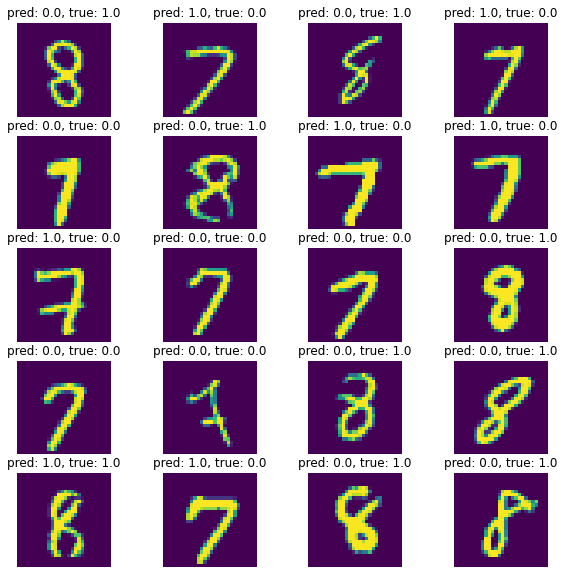

In [379]:
random_indices = np.random.randint(0, high=x_test.shape[0], size=20).reshape(5,4)
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(10,10))
fig.figsize=(10,10)

for i in range(5):
    for j in range(4):
        ax[i,j].imshow(x_test[random_indices[i,j]])
        ax[i,j].set_title(f"pred: {lusi_net_test_pred[random_indices[i,j]][0]}, true: {y_test[random_indices[i,j]]}")
        ax[i,j].axis("off")

In [207]:
lusi_net.watches_vars

(<tf.Variable 'hidden_layer_01/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[ 0.01029615,  0.07308923,  0.0528736 , ...,  0.01764344,
          0.03428844,  0.06806841],
        [ 0.04321082, -0.03620856, -0.07285321, ...,  0.00256582,
          0.01069878,  0.01379132],
        [-0.01839224, -0.00344887, -0.04425785, ..., -0.03740519,
          0.0312849 , -0.04990429],
        ...,
        [-0.06186682,  0.0360487 ,  0.07773726, ..., -0.03847785,
         -0.07957546, -0.02448065],
        [ 0.05378409, -0.07762517,  0.04541375, ...,  0.03921954,
          0.07320769,  0.00610677],
        [ 0.05557923, -0.00094198, -0.05384734, ..., -0.02304952,
          0.0453769 , -0.02132869]], dtype=float32)>,
 <tf.Variable 'hidden_layer_01/bias:0' shape=(100,) dtype=float32, numpy=
 array([ 2.26809527e-04,  3.96134565e-03, -4.38527612e-04, -5.05398260e-04,
         4.54691658e-03, -2.63975060e-04, -2.56159110e-04, -3.66585399e-03,
        -8.84142704e-03,  2.18607159e-03, -4.288167

In [240]:
temp = (lusi_net.model_weight_list[4][1][0] - lusi_net.model_weight_list[15][1][0])

In [245]:
print(np.max(temp[temp != 0]))
print(np.min(temp[temp != 0]))


0.0033567557
-0.004465893


In [230]:
lusi_net.layers[0].get_weights()

[array([[ 4.8890710e-05,  3.0188531e-02, -4.0214725e-02, ...,
         -1.3065308e-02, -2.8753571e-02, -4.9196303e-02],
        [-7.3631488e-02,  4.3032289e-02, -6.9208182e-02, ...,
         -7.8303888e-02,  2.5965855e-02,  5.5982769e-02],
        [ 4.7780767e-02, -6.9650389e-02, -3.1469338e-02, ...,
          1.7053321e-02, -2.0180274e-02,  6.0287729e-02],
        ...,
        [ 4.6156347e-02, -1.6654171e-02, -1.3102941e-02, ...,
          3.8317069e-02,  4.9839109e-02, -4.5718636e-02],
        [-5.2456081e-02,  7.4608058e-02, -2.8712895e-02, ...,
         -2.5966190e-02, -2.2572141e-02, -4.1668400e-02],
        [ 7.1549192e-02,  1.4410384e-02, -4.1738898e-02, ...,
         -5.7290137e-02,  4.4993132e-02,  1.8160544e-02]], dtype=float32),
 array([ 5.7783659e-04, -1.3924793e-03, -5.2779360e-04, -4.4235124e-04,
        -1.4338095e-03, -5.7914876e-05,  1.1531371e-02, -2.4699224e-03,
         2.2904804e-02,  5.6161243e-05,  3.2234148e-04, -4.1506483e-04,
         4.5874060e-04,  1.7970765

In [178]:
lusi_net.model_weight_list[4]

((0, 3),
 ListWrapper([array([[-0.03290785, -0.0049599 , -0.06872204, ..., -0.02190971,
          0.04855919,  0.048613  ],
        [-0.04266789, -0.03542301,  0.02982783, ..., -0.06789184,
          0.01476679,  0.01816675],
        [-0.0708926 ,  0.00394389,  0.0236842 , ...,  0.05096431,
         -0.05892266,  0.06849761],
        ...,
        [ 0.0201686 ,  0.04717921,  0.0217082 , ..., -0.0435766 ,
         -0.02208497, -0.08158264],
        [-0.00258563,  0.05347441,  0.02945437, ..., -0.05903338,
          0.02728259,  0.06087816],
        [-0.05981946, -0.0771868 , -0.03381646, ...,  0.03348702,
         -0.07569855, -0.07999133]], dtype=float32), array([ 4.5682047e-04,  3.8227742e-03,  5.5619900e-04, -5.8357842e-04,
        -1.4825790e-04, -1.0391799e-03, -5.1099993e-04, -1.0579149e-03,
         1.1329939e-04,  2.3807606e-03, -1.0065484e-03, -2.8342973e-03,
         2.6445771e-03, -1.3772832e-03, -3.7042033e-03,  2.5061311e-04,
         3.0714814e-03,  1.5233811e-03,  2.200921

### Temporary Issues - old implementation -> ignore

**Issue no 1.**

Während des Trainings kann man einsehen, dass alle Modellparameter des neuronales Netztes vom gradient tape beobachtet werden. Problematisch ist alelrdings, dass man für die erste Matrix von der Dim (784, 100) des ersten Layers immer 0 als Gradienten erhält. Die restlichen Gradienten sind nicht 0.

**Geklärt!!!** Ist beim neuen Modell nicht mehr so...

Trotzdem gut zur Illustration

In [174]:
lusi_net = lal.LusiModel(predicates=None, weight_matrix=weight_matrix)
lusi_net.add_optimizer(tf.keras.optimizers.SGD())
lusi_net.evaluate(test_dataset, eval_metrics)

[('Binary Accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.8142556>),
 ('False Positives', <tf.Tensor: shape=(), dtype=float32, numpy=848.0>),
 ('False Negatives', <tf.Tensor: shape=(), dtype=float32, numpy=274.0>),
 ('Precision', <tf.Tensor: shape=(), dtype=float32, numpy=0.83850694>),
 ('Recall', <tf.Tensor: shape=(), dtype=float32, numpy=0.9414154>),
 ('Mean', <tf.Tensor: shape=(), dtype=float32, numpy=-0.24690153>),
 ('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.80301964>)]

In [175]:
# Train custom model for 10 epochs
lusi_net.train_debug(train_dataset, 5, train_metrics=eval_metrics,  batch_1_size=32)


Start of epoch 0
Training loss (for one batch) at step 0: -1.1264
Seen so far: 64 samples
Training loss (for one batch) at step 100: 1.2990
Seen so far: 6464 samples

Start of epoch 1
Training loss (for one batch) at step 0: -0.6952
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.3608
Seen so far: 6464 samples

Start of epoch 2
Training loss (for one batch) at step 0: -1.1882
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.1167
Seen so far: 6464 samples

Start of epoch 3
Training loss (for one batch) at step 0: -0.8993
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.2571
Seen so far: 6464 samples

Start of epoch 4
Training loss (for one batch) at step 0: -0.6263
Seen so far: 64 samples
Training loss (for one batch) at step 100: 0.1625
Seen so far: 6464 samples


In [186]:
lusi_net.model_weight_list[0]

(-1,
 ListWrapper([<tf.Variable 'hidden_layer_01/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[-0.0370429 ,  0.01856136,  0.01109488, ..., -0.00165075,
         -0.04981851, -0.03788538],
        [-0.08224574, -0.0169937 , -0.06788497, ..., -0.04744552,
         -0.07561758, -0.00373816],
        [-0.03309216, -0.0767751 ,  0.02286159, ...,  0.04550548,
          0.01688451, -0.04940302],
        ...,
        [-0.01363045,  0.0018331 ,  0.00059545, ..., -0.05137364,
          0.01653846,  0.01442146],
        [-0.06955153,  0.06206992, -0.02738059, ...,  0.05478401,
          0.02380726,  0.07367747],
        [-0.0182959 , -0.0309881 , -0.06341801, ..., -0.08149514,
          0.062833  , -0.03134453]], dtype=float32)>, <tf.Variable 'hidden_layer_01/bias:0' shape=(100,) dtype=float32, numpy=
 array([ 1.1756525e-02,  1.1458894e-02,  5.1763508e-04,  1.1784678e-03,
         2.3810772e-04, -7.2968501e-04,  1.9484211e-02,  6.7639253e-03,
        -3.4178586e-03, -2.4401019e-03,  2

In [179]:
diff_grad = (lusi_net.gradient_list[0][1][0] - lusi_net.gradient_list[50][1][0]).numpy()

In [181]:
np.max(diff_grad)

0.086509906

In [182]:
np.min(diff_grad)

-0.080651

In [100]:
diff_grad[diff_grad != 0].shape

(37018,)

In [102]:
(lusi_net.gradient_list[0][1][0]).numpy().shape

(784, 100)

**Issue no 2.**

Der Optimizer führt die Gradientenupdates nicht durch. Das Modell scheint aber ja, wie man sieht, dennoch angepasst zu werden.



In [187]:
print(f"Weights for epoch {lusi_net.model_weight_list[1][0][0]} step {lusi_net.model_weight_list[1][0][1]}: ")
lusi_net.model_weight_list[0][1][0]

Weights for epoch 0 step 0: 


<tf.Variable 'hidden_layer_01/kernel:0' shape=(784, 100) dtype=float32, numpy=
array([[-0.0370429 ,  0.01856136,  0.01109488, ..., -0.00165075,
        -0.04981851, -0.03788538],
       [-0.08224574, -0.0169937 , -0.06788497, ..., -0.04744552,
        -0.07561758, -0.00373816],
       [-0.03309216, -0.0767751 ,  0.02286159, ...,  0.04550548,
         0.01688451, -0.04940302],
       ...,
       [-0.01363045,  0.0018331 ,  0.00059545, ..., -0.05137364,
         0.01653846,  0.01442146],
       [-0.06955153,  0.06206992, -0.02738059, ...,  0.05478401,
         0.02380726,  0.07367747],
       [-0.0182959 , -0.0309881 , -0.06341801, ..., -0.08149514,
         0.062833  , -0.03134453]], dtype=float32)>

In [190]:
print(f"Weights for epoch {lusi_net.model_weight_list[400][0][0]} step {lusi_net.model_weight_list[40][0][1]}: ")
lusi_net.model_weight_list[1][1][0]

Weights for epoch 2 step 39: 


array([[-0.0370429 ,  0.01856136,  0.01109488, ..., -0.00165075,
        -0.04981851, -0.03788538],
       [-0.08224574, -0.0169937 , -0.06788497, ..., -0.04744552,
        -0.07561758, -0.00373816],
       [-0.03309216, -0.0767751 ,  0.02286159, ...,  0.04550548,
         0.01688451, -0.04940302],
       ...,
       [-0.01363045,  0.0018331 ,  0.00059545, ..., -0.05137364,
         0.01653846,  0.01442146],
       [-0.06955153,  0.06206992, -0.02738059, ...,  0.05478401,
         0.02380726,  0.07367747],
       [-0.0182959 , -0.0309881 , -0.06341801, ..., -0.08149514,
         0.062833  , -0.03134453]], dtype=float32)

### Remarks and ToDos 07.05.

- in Periphery, do not take n_train, n_test as args. Expected to pass train and test set of desired size already
- params should be: bs_1, bs_2, preds,  